In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

import os
data_folder = '../data/'
pictures = os.listdir(data_folder)

block = 8

def showImage(img):
    plt.figure(figsize=(15,15))
    plt.imshow(img,cmap='gray')
    plt.xticks([]),plt.yticks([])
    plt.show()

def selectQMatrix(qName):
    Q10 = np.array([[80,60,50,80,120,200,255,255],
                [55,60,70,95,130,255,255,255],
                [70,65,80,120,200,255,255,255],
                [70,85,110,145,255,255,255,255],
                [90,110,185,255,255,255,255,255],
                [120,175,255,255,255,255,255,255],
                [245,255,255,255,255,255,255,255],
                [255,255,255,255,255,255,255,255]])

    Q50 = np.array([[16,11,10,16,24,40,51,61],
                [12,12,14,19,26,58,60,55],
                [14,13,16,24,40,57,69,56],
                [14,17,22,29,51,87,80,62],
                [18,22,37,56,68,109,103,77],
                [24,35,55,64,81,104,113,92],
                [49,64,78,87,103,121,120,101],
                [72,92,95,98,112,100,130,99]])

    Q90 = np.array([[3,2,2,3,5,8,10,12],
                    [2,2,3,4,5,12,12,11],
                    [3,3,3,5,8,11,14,11],
                    [3,3,4,6,10,17,16,12],
                    [4,4,7,11,14,22,21,15],
                    [5,7,11,13,16,12,23,18],
                    [10,13,16,17,21,24,24,21],
                    [14,18,19,20,22,20,20,20]])
    if qName == "Q10":
        return Q10
    elif qName == "Q50":
        return Q50
    elif qName == "Q90":
        return Q90
    else:
        return np.ones((8,8)) #it suppose to return original image back

## Load image in grayscale, convert it into float and normalize data

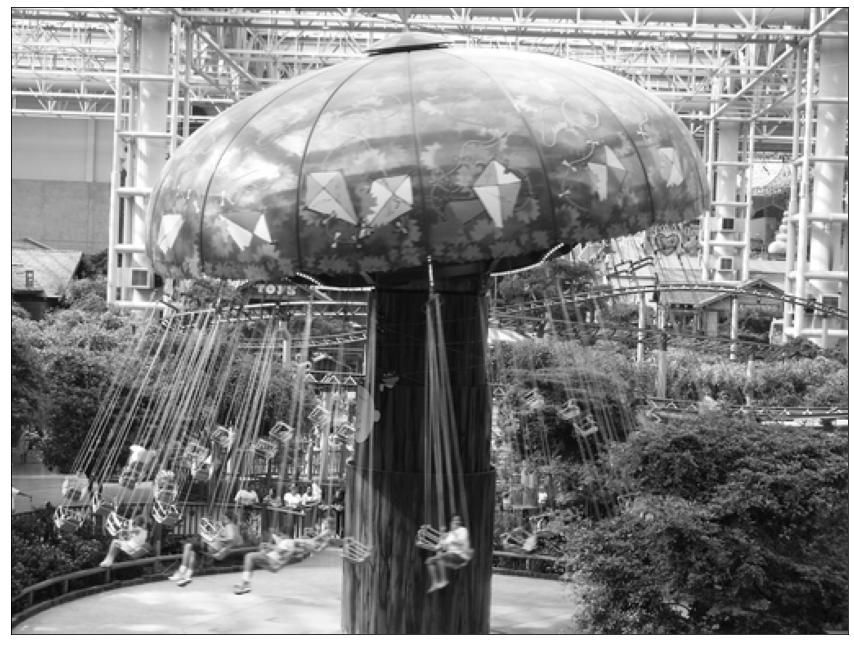

In [2]:
img = cv2.imread(data_folder + pictures[0], 0)
img = np.float32(img) - 128
showImage(img)


## Slice the image into a list of 8x8 blocks

In [3]:
def sclice_image(image):
    height, width = image.shape
    sliced = [] # new list for 8x8 sliced image
    #dividing 8x8 parts
    currY = 0 #current Y index
    for i in range(block,height+1,block):
        currX = 0 #current X index
        for j in range(block,width+1,block):
            sliced.append(img[currY:i,currX:j])
            currX = j
        currY = i
    return sliced

sliced = sclice_image(img)

## Compute DCT for each 8x8 block

In [4]:
def compute_dct(sliced_img):
    dct_output = [cv2.dct(part) for part in sliced_img]
    return dct_output

DCToutput = compute_dct(sliced)

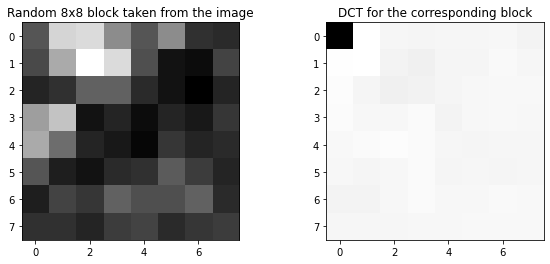

In [5]:
fig = plt.figure(figsize=(10,4))

block_number = np.random.randint(0, len(sliced))

plt.subplot(121)
plt.title("Random 8x8 block taken from the image")
plt.imshow(sliced[block_number], cmap='gray')

plt.subplot(122)
plt.title("DCT for the corresponding block")
plt.imshow(DCToutput[block_number], cmap='gray')

plt.show()

## Quantification

In [6]:
def quantification(dct_output, selected_qmatrix, around=np.around):
    quantification_output = []
    for block_dct in dct_output:
        quantification_output.append(around(block_dct/selected_qmatrix))
    return quantification_output

quantiOutput = quantification(DCToutput, selectQMatrix("Q10"), np.around)

## Inverse quantification

In [7]:
def inverse_quantification(quantiOutput, selected_qmatrix, around=np.around):
    inverse_quantiOutput = []
    for block_dct in quantiOutput:
        inverse_quantiOutput.append(around(block_dct*selected_qmatrix))
    return inverse_quantiOutput

inverse_quantiOutput = inverse_quantification(quantiOutput, selectQMatrix("Q10"), np.around)

## Inverse DCT transform

In [8]:
def compute_idct(inverse_quantiOutput):
    invList = [cv2.idct(ipart) for ipart in inverse_quantiOutput]
    return invList

idct_output = compute_idct(inverse_quantiOutput)

## Putting the image parts together

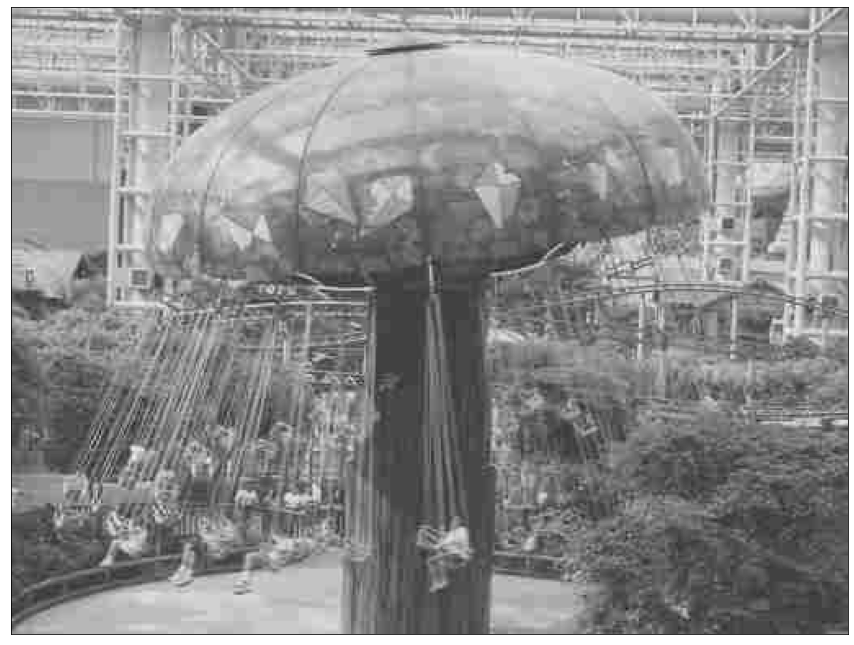

In [9]:
def unsclice_image(idct_output, img_width):
    row = 0
    rowNcol = []
    for j in range(int(img_width/block),len(idct_output)+1,int(img_width/block)):
        rowNcol.append(np.hstack((idct_output[row:j])))
        row = j
    res = np.vstack((rowNcol))
    return res

res = unsclice_image(idct_output, img.shape[1])
showImage(res)

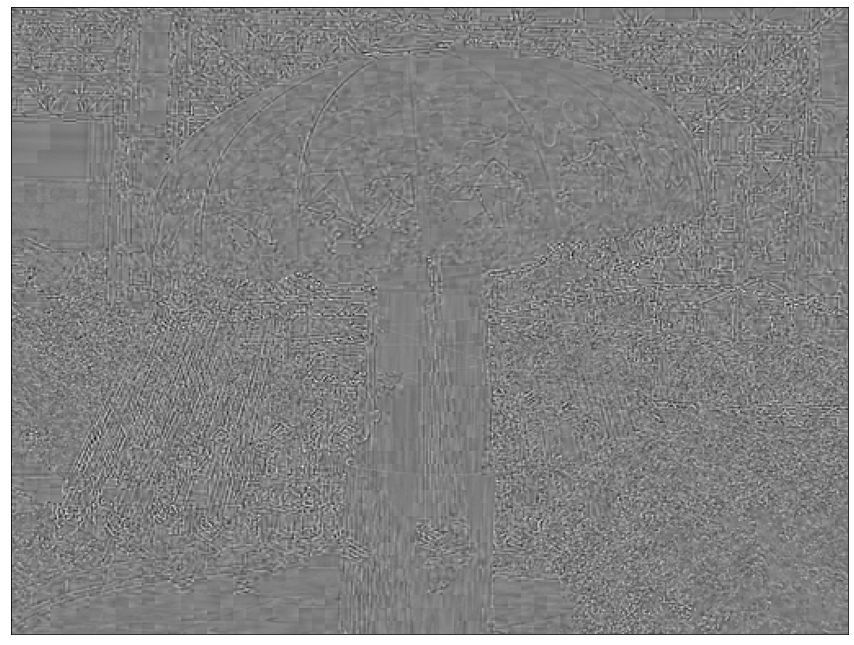

In [10]:
errors = img - res
showImage(errors)